In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# file_path = "Processed_Data/Mapped_Dataset.csv"
# file_path="C:/Users/hoang/FileCSV_DACN_2025/Benign_ddos_dos_Mapped_Dataset.csv"
file_path = "remapping_dataset_multiclass.csv"

df = dk.read_csv(file_path)

2025-04-28 10:31:08.996977: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 10:31:09.208421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745811069.283795     461 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745811069.303342     461 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745811069.456137     461 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

label
3    2634124
1    4999999
0    1098195
2    4999999
Name: count, dtype: int64


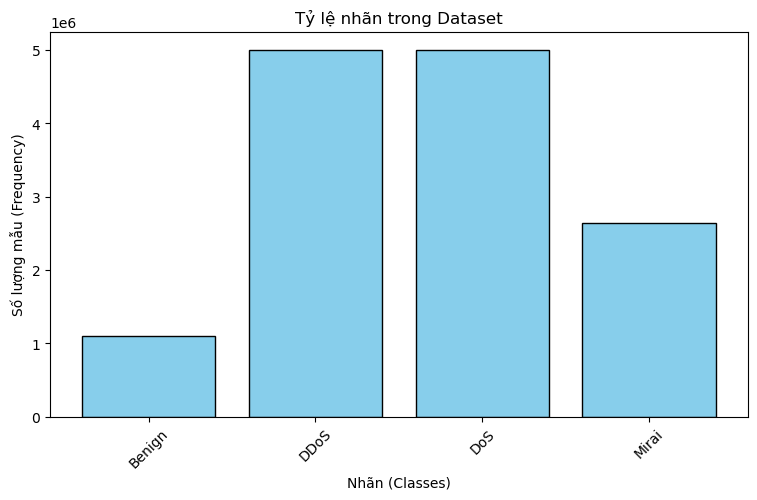

In [2]:
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts().compute()
ordered_labels = [0, 1, 2, 3]
ordered_counts = [label_counts.get(label, 0) for label in ordered_labels] 
print(label_counts)
labels = ["Benign","DDoS","DoS","Mirai"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, ordered_counts, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [3]:
#Global var 
batch_size = 256
ratio_test_all = 0.15

from dask_ml.model_selection import train_test_split 
# chia train test ratio 0.8:0.2 & random 
train_df, test_df = train_test_split(df, test_size=ratio_test_all, random_state=42)

# # load từng batch
def dask_to_tf_dataset(dask_df, batch_size): 
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)  # nhị phân: 0 hoặc 1

            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch

    output_signature = ( 
        tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),  # không phải one-hot nữa
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [4]:
train_gen = dask_to_tf_dataset(train_df, 256).repeat()
test_gen = dask_to_tf_dataset(test_df, 256)

I0000 00:00:1745811080.318183     461 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
from datetime import datetime, timedelta
import sys, os
# shape
features, labels = next(iter(train_gen))
input_shape = (features.shape[1], 1)
# output_shape = labels.shape[1]

print(f"Input Shape: {input_shape}")

from tensorflow import keras
# Định nghĩa mô hình CNN
# VGG, ...
# Conv2D, tabular, ...
# HE, tính tương thích của HE với CNN
# Tính chất data in, out; Học tăng cường
start_time = datetime.now()

model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling1D(pool_size=4),
    layers.Conv1D(filters=64, kernel_size=3,  padding="same",activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(4, activation='softmax')  # dùng sigmoid thay cho softmax
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# for batch in dataloader:
#     X_batch = batch[:, :-1]
#     y_batch = batch[:, -1]
#     y_onehot = to_categorical(y_batch, num_classes=10)
    
#     model.train_on_batch(X_batch, y_onehot, verbose=1)
from tensorflow.keras.callbacks import CSVLogger
os.makedirs("log_mono", exist_ok=True)
csv_logger = CSVLogger("log_mono/"+ datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".csv" , append=True)
model.fit(train_gen, epochs=25, steps_per_epoch=45590, verbose = 1, callbacks=[csv_logger])


end_time = datetime.now()
simulated_time = end_time - start_time

# Lưu mô hình
model.save("saved_model/cnn_model_2-0_batch512_" + datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".keras")

print(f"Simulated time: {simulated_time}")

Input Shape: (46, 1)
Epoch 1/25


I0000 00:00:1745811082.741856     543 service.cc:152] XLA service 0x7f60c000c6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745811082.741931     543 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-04-28 10:31:22.781977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745811082.952378     543 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-28 10:31:23.978173: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1089_0', 56 bytes spill stores, 56 bytes spill loads

2025-04-28 10:31:24.049909: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

   58/45590 ━━━━━━━━━━━━━━━━━━━━ 2:05 3ms/step - accuracy: 0.3439 - loss: 1.5004

I0000 00:00:1745811086.138551     543 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45590/45590 ━━━━━━━━━━━━━━━━━━━━ 178s 4ms/step - accuracy: 0.9904 - loss: 0.0331
Epoch 2/25
45590/45590 ━━━━━━━━━━━━━━━━━━━━ 211s 5ms/step - accuracy: 0.9959 - loss: 0.0168
Epoch 3/25
45590/45590 ━━━━━━━━━━━━━━━━━━━━ 242s 5ms/step - accuracy: 0.9965 - loss: 0.0144
Epoch 4/25
45590/45590 ━━━━━━━━━━━━━━━━━━━━ 219s 5ms/step - accuracy: 0.9966 - loss: 0.0139
Epoch 5/25
45590/45590 ━━━━━━━━━━━━━━━━━━━━ 252s 6ms/step - accuracy: 0.9966 - loss: 0.0140
Epoch 6/25
45590/45590 ━━━━━━━━━━━━━━━━━━━━ 211s 5ms/step - accuracy: 0.9967 - loss: 0.0138
Epoch 7/25
45590/45590 ━━━━━━━━━━━━━━━━━━━━ 232s 5ms/step - accuracy: 0.9966 - loss: 0.0142
Epoch 8/25
45590/45590 ━━━━━━━━━━━━━━━━━━━━ 234s 5ms/step - accuracy: 0.9967 - loss: 0.0133
Epoch 9/25
45590/45590 ━━━━━━━━━━━━━━━━━━━━ 209s 5ms/step - accuracy: 0.9967 - loss: 0.0136
Epoch 10/25
45590/45590 ━━━━━━━━━━━━━━━━━━━━ 221s 5ms/step - accuracy: 0.9967 - loss: 0.0130
Epoch 11/25
45590/45590 ━━━━━━━━━━━━━━━━━━━━ 239s 5ms/step - accuracy: 0.9967 - loss: 0.01

In [7]:
from tensorflow.keras.models import load_model
#input_model = "saved_model/cnn_model_2-0_batch512_" + datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".keras"
model = load_model("saved_model/cnn_model_2-0_batch512_12h07p__28-04-2025.keras")

output = model.evaluate(test_gen, steps = 8046)
print(f'Loss: {output[0]} Acc: {output[1]}')

8046/8046 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.7310 - loss: 4.3847
Loss: 10.878862380981445 Acc: 0.3822169601917267


2025-04-28 12:12:08.928508: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-28 12:12:08.928637: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-28 12:12:08.928645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8566107828029583695
2025-04-28 12:12:08.928673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 546116832715741050
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when

Batch test:  8045
Samples in y_true: 2059312, Samples in y_pred: 2059312

Classification Report:
              precision    recall  f1-score   support

           0     0.9931    0.2177    0.3571    165585
           1     0.3706    0.9999    0.5408    748970
           2     0.0000    0.0000    0.0000    749791
           3     0.9825    0.0054    0.0107    394966

    accuracy                         0.3822   2059312
   macro avg     0.5865    0.3058    0.2272   2059312
weighted avg     0.4031    0.3822    0.2275   2059312


Macro Average:
Precision: 0.5865
Recall: 0.3058
F1-Score: 0.2272


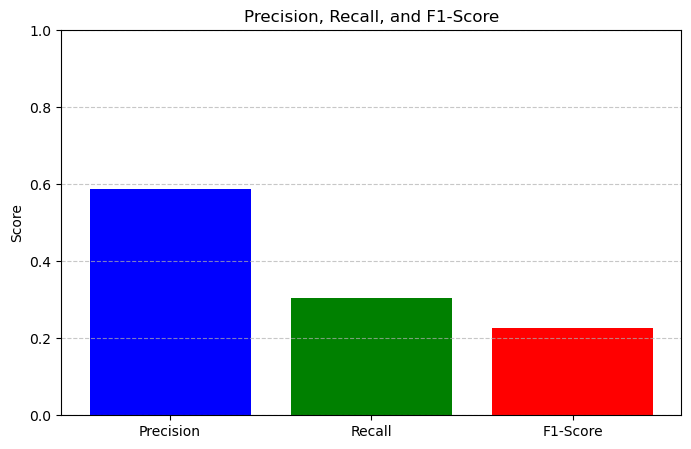

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

#input_model = "/home/hoangvn/Enhancing_PP_of_FL_for_IDS/saved_model/cnn_model_2-0_batch512_10h07p__13-04-2025.keras"
model = load_model("saved_model/cnn_model_2-0_batch512_12h07p__28-04-2025.keras")

# Tính số hàng thật sự trong test_df
num_samples_test = test_df.shape[0].compute()
# Tính số batch
num_batches_test = int(np.ceil(num_samples_test / batch_size))
print("Batch test: ", num_batches_test)

y_true_all = []
y_pred_all = []

for X_batch, y_batch in test_gen.take(num_batches_test):
    # Giữ nguyên y_true (không flatten nếu đã là integer labels)
    y_true_all.extend(y_batch.numpy())  
    
    # Dự đoán và lấy class có xác suất cao nhất
    y_pred_prob = model.predict(X_batch, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Shape (batch_size,)
    y_pred_all.extend(y_pred)

# Đảm bảo số lượng mẫu khớp
print(f"Samples in y_true: {len(y_true_all)}, Samples in y_pred: {len(y_pred_all)}")

# Tính metrics
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, digits=4))

precision = precision_score(y_true_all, y_pred_all, average='macro')
recall = recall_score(y_true_all, y_pred_all, average='macro')
f1 = f1_score(y_true_all, y_pred_all, average='macro')

print(f"\nMacro Average:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

param_names = ['Precision', 'Recall', 'F1-Score']
array = [precision, recall, f1]

x = np.arange(len(param_names))
width = 0.2  # Độ rộng của mỗi cột
plt.figure(figsize=(8, 5))
plt.bar(param_names, array, color=['blue', 'green', 'red'])

# Cấu hình trục và nhãn
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score")
plt.ylim(0, 1)  # Giá trị từ 0 đến 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()


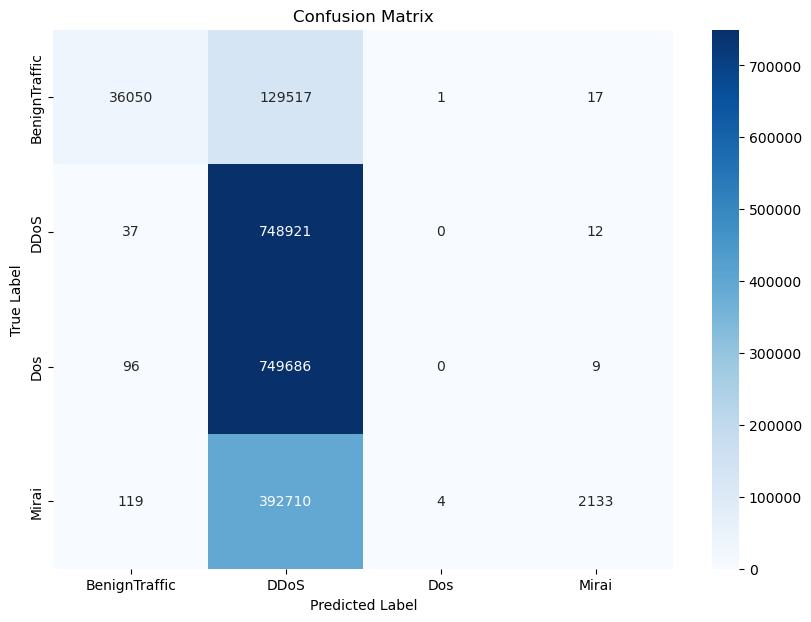

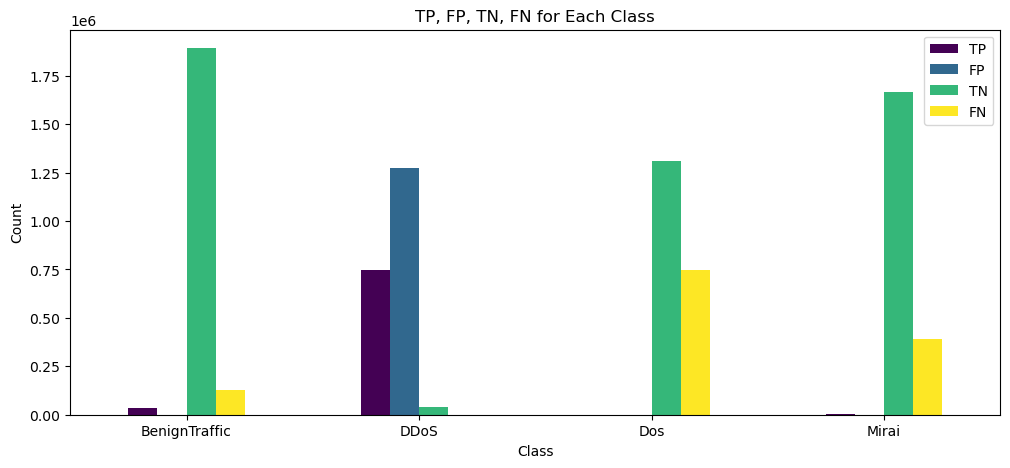

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true_all, y_pred_all)

attack_types =['BenignTraffic', 'DDoS','Dos', 'Mirai']
# Vẽ heatmap
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Hiển thị
plt.show()


metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()